### imports

In [117]:
import sys
import os
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# Caminho da pasta "Twitch"
base_dir = Path(os.getcwd()).resolve().parent  # Ajuste se necessário

# Adicionar as pasta ao sys.path
visualization_dir = base_dir / 'src' / 'visualization'
getData_dir = base_dir / 'src' / 'data'
sys.path.append(str(visualization_dir))
sys.path.append(str(getData_dir))

# Importar os módulos
try:
    import community_visualization
    import correlations
    import TwitchGraphs
    import TwitchVisualization
except ImportError:
    print("Erro: Não foi possível importar algum módulo. Verifique se o caminho está correto.")

# Paises
countries = ["PTBR", "DE", "ENGB", "ES", "FR", "RU"]

## Visualização das correlações

#### Selecionar o País

In [118]:
# Escolher entre: DE, ENGB, ES, FR, PTBR, RU
country = "ENGB"

#### Definir o diretório correto

In [119]:
# Carregar dados
csv_path = base_dir / 'data' / country / 'processed_data' / f"twitch_network_analysis_{country}.csv"
output_dir = base_dir / 'docs' / "Imagens"
output_dir.mkdir(exist_ok=True)

# Ler dados
df = pd.read_csv(csv_path)
df.head()

,node,degree,degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality,pagerank_centrality,clustering_coef,louvain_community,lp_community,...,created_at,profile_pic,broadcaster_type,game_name,day_of_year,is_leap,days_in_year,normalized_day,sin_created_at,cos_created_at
0,2299,7,0.000982,0.303127,0.000434,0.009085,0.000123,0.142857,19,0,...,2014-10-14,https://static-cdn.jtvnw.net/jtv_user_pictures...,affiliate,Planet Zoo,287.0,False,365,4.923263,-0.977848,0.209315
1,153,19,0.002667,0.330014,0.000828,0.018881,0.000237,0.093567,17,0,...,2014-04-25,https://static-cdn.jtvnw.net/jtv_user_pictures...,affiliate,Napoleon: Total War,115.0,False,365,1.962420,0.924291,-0.381689
2,397,9,0.001263,0.285938,0.000044,0.004724,0.000122,0.055556,2,0,...,2017-08-27,https://static-cdn.jtvnw.net/jtv_user_pictures...,affiliate,Food & Drink,239.0,False,365,4.096981,-0.816538,-0.577292
3,5623,3,0.000421,0.261487,0.000004,0.000855,0.000052,0.000000,3,0,...,2016-02-29,https://static-cdn.jtvnw.net/user-default-pict...,affiliate,NaN,60.0,True,366,1.012863,0.848351,0.529434
4,5875,2,0.000281,0.294555,0.000030,0.006433,0.000055,0.000000,4,1,...,2016-10-01,https://static-cdn.jtvnw.net/jtv_user_pictures...,affiliate,Minecraft,275.0,True,366,4.703805,-0.999963,-0.008583


### Arranjar o tipo das variáveis

In [120]:
df['created_at'] = pd.to_datetime(df['created_at'], format='%Y-%m-%d')
df['created_year'] = df['created_at'].dt.year
df['mature'] = df['mature'].astype(int)
df['partner'] = df['partner'].astype(int)
df = df.drop(columns=['id', 'node', 'new_id', 'username', 'profile_pic', 'created_at', 'day_of_year', 'normalized_day', 'is_leap', 'days_in_year', 'broadcaster_type'])
df.head()

,degree,degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality,pagerank_centrality,clustering_coef,louvain_community,lp_community,days,mature,views,partner,game_name,sin_created_at,cos_created_at,created_year
0,7,0.000982,0.303127,0.000434,0.009085,0.000123,0.142857,19,0,3711,0,9528,0,Planet Zoo,-0.977848,0.209315,2014.0
1,19,0.002667,0.330014,0.000828,0.018881,0.000237,0.093567,17,0,3883,1,3615,0,Napoleon: Total War,0.924291,-0.381689,2014.0
2,9,0.001263,0.285938,0.000044,0.004724,0.000122,0.055556,2,0,2663,1,46546,0,Food & Drink,-0.816538,-0.577292,2017.0
3,3,0.000421,0.261487,0.000004,0.000855,0.000052,0.000000,3,0,3208,1,5863,0,NaN,0.848351,0.529434,2016.0
4,2,0.000281,0.294555,0.000030,0.006433,0.000055,0.000000,4,1,2993,1,5594,0,Minecraft,-0.999963,-0.008583,2016.0


In [121]:
df.dtypes

degree                      int64
degree_centrality         float64
closeness_centrality      float64
betweenness_centrality    float64
eigenvector_centrality    float64
pagerank_centrality       float64
clustering_coef           float64
louvain_community           int64
lp_community                int64
days                        int64
mature                      int64
views                       int64
partner                     int64
game_name                  object
sin_created_at            float64
cos_created_at            float64
created_year              float64
dtype: object

#### Games

In [122]:
# Lista de categorias que NÃO são jogos
nao_jogos = ['IRL', 'Just Chatting', 'Watch TV']

df['isGame'] = df['game_name'].apply(
    lambda x: -1 if pd.isna(x) else (0 if x in nao_jogos else 1)
)


In [123]:
df.head()

,degree,degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality,pagerank_centrality,clustering_coef,louvain_community,lp_community,days,mature,views,partner,game_name,sin_created_at,cos_created_at,created_year,isGame
0,7,0.000982,0.303127,0.000434,0.009085,0.000123,0.142857,19,0,3711,0,9528,0,Planet Zoo,-0.977848,0.209315,2014.0,1
1,19,0.002667,0.330014,0.000828,0.018881,0.000237,0.093567,17,0,3883,1,3615,0,Napoleon: Total War,0.924291,-0.381689,2014.0,1
2,9,0.001263,0.285938,0.000044,0.004724,0.000122,0.055556,2,0,2663,1,46546,0,Food & Drink,-0.816538,-0.577292,2017.0,1
3,3,0.000421,0.261487,0.000004,0.000855,0.000052,0.000000,3,0,3208,1,5863,0,NaN,0.848351,0.529434,2016.0,-1
4,2,0.000281,0.294555,0.000030,0.006433,0.000055,0.000000,4,1,2993,1,5594,0,Minecraft,-0.999963,-0.008583,2016.0,1


In [124]:
# Identificar se o jogo é popular (e.g., Top 10% mais vistos)
popular_games_threshold = df['views'].quantile(0.9)  # Ajusta o percentil conforme necessário

# Filtrar os jogos que atingem o limiar
popular_games = df.loc[df['views'] >= popular_games_threshold, 'game_name'].unique()

# Criar a variável binária 'is_popular_game'
df['is_popular_game'] = df['game_name'].apply(lambda x: 1 if x in popular_games else 0)

df.drop(["game_name"], axis=1, inplace=True)

### Categoricas


In [125]:
# Broadcaster Type em uma variavel categorica
df['louvain_community'] =  df['louvain_community'].astype('category')
df['lp_community'] =  df['lp_community'].astype('category')
df['partner'] =  df['partner'].astype('category')
df['mature'] =  df['mature'].astype('category')
df['isGame'] =  df['isGame'].astype('category')
df['is_popular_game'] =  df['is_popular_game'].astype('category')


#### Variáveis Extras

In [126]:
df.dtypes


degree                       int64
degree_centrality          float64
closeness_centrality       float64
betweenness_centrality     float64
eigenvector_centrality     float64
pagerank_centrality        float64
clustering_coef            float64
louvain_community         category
lp_community              category
days                         int64
mature                    category
views                        int64
partner                   category
sin_created_at             float64
cos_created_at             float64
created_year               float64
isGame                    category
is_popular_game           category
dtype: object

In [127]:
df.head()

,degree,degree_centrality,closeness_centrality,betweenness_centrality,eigenvector_centrality,pagerank_centrality,clustering_coef,louvain_community,lp_community,days,mature,views,partner,sin_created_at,cos_created_at,created_year,isGame,is_popular_game
0,7,0.000982,0.303127,0.000434,0.009085,0.000123,0.142857,19,0,3711,0,9528,0,-0.977848,0.209315,2014.0,1,0
1,19,0.002667,0.330014,0.000828,0.018881,0.000237,0.093567,17,0,3883,1,3615,0,0.924291,-0.381689,2014.0,1,0
2,9,0.001263,0.285938,0.000044,0.004724,0.000122,0.055556,2,0,2663,1,46546,0,-0.816538,-0.577292,2017.0,1,1
3,3,0.000421,0.261487,0.000004,0.000855,0.000052,0.000000,3,0,3208,1,5863,0,0.848351,0.529434,2016.0,-1,0
4,2,0.000281,0.294555,0.000030,0.006433,0.000055,0.000000,4,1,2993,1,5594,0,-0.999963,-0.008583,2016.0,1,1


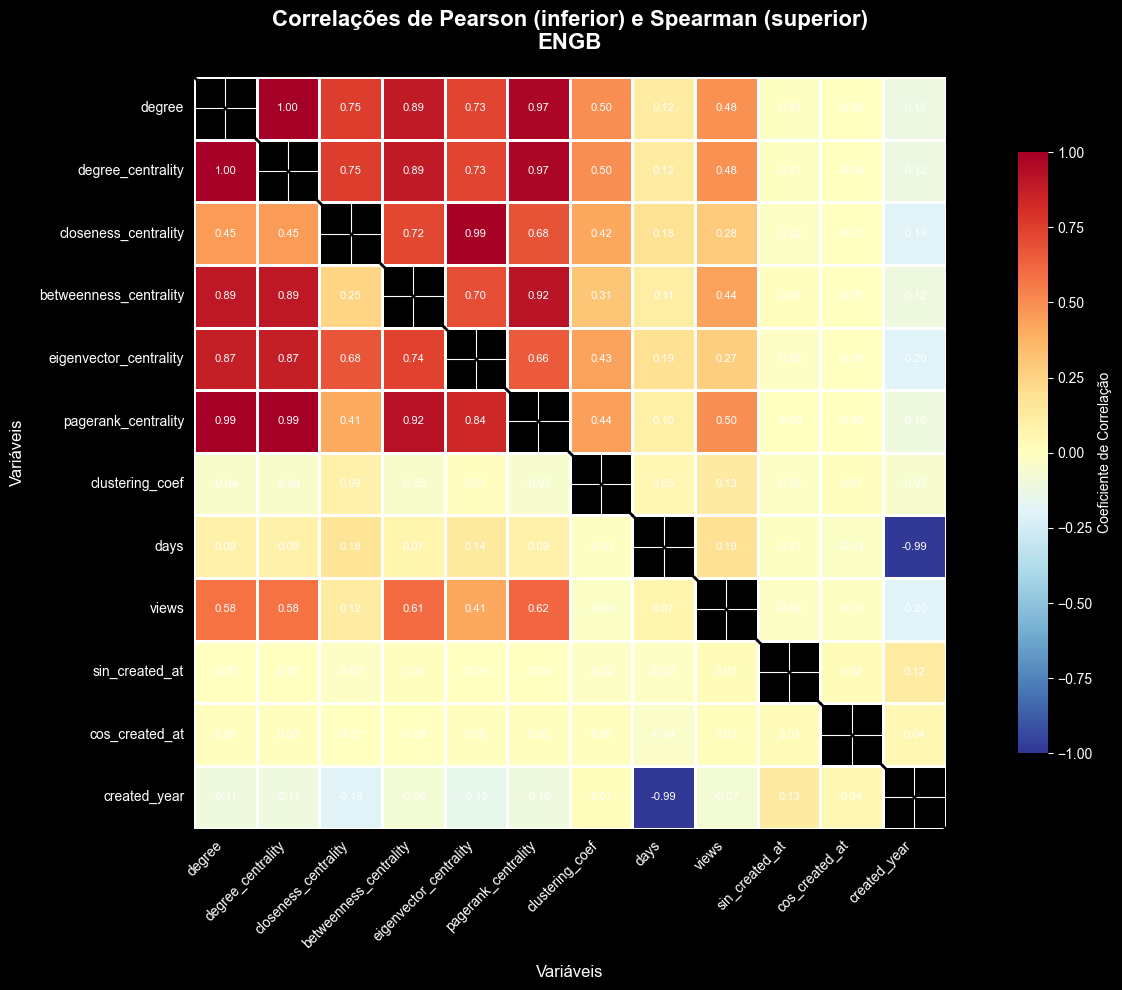

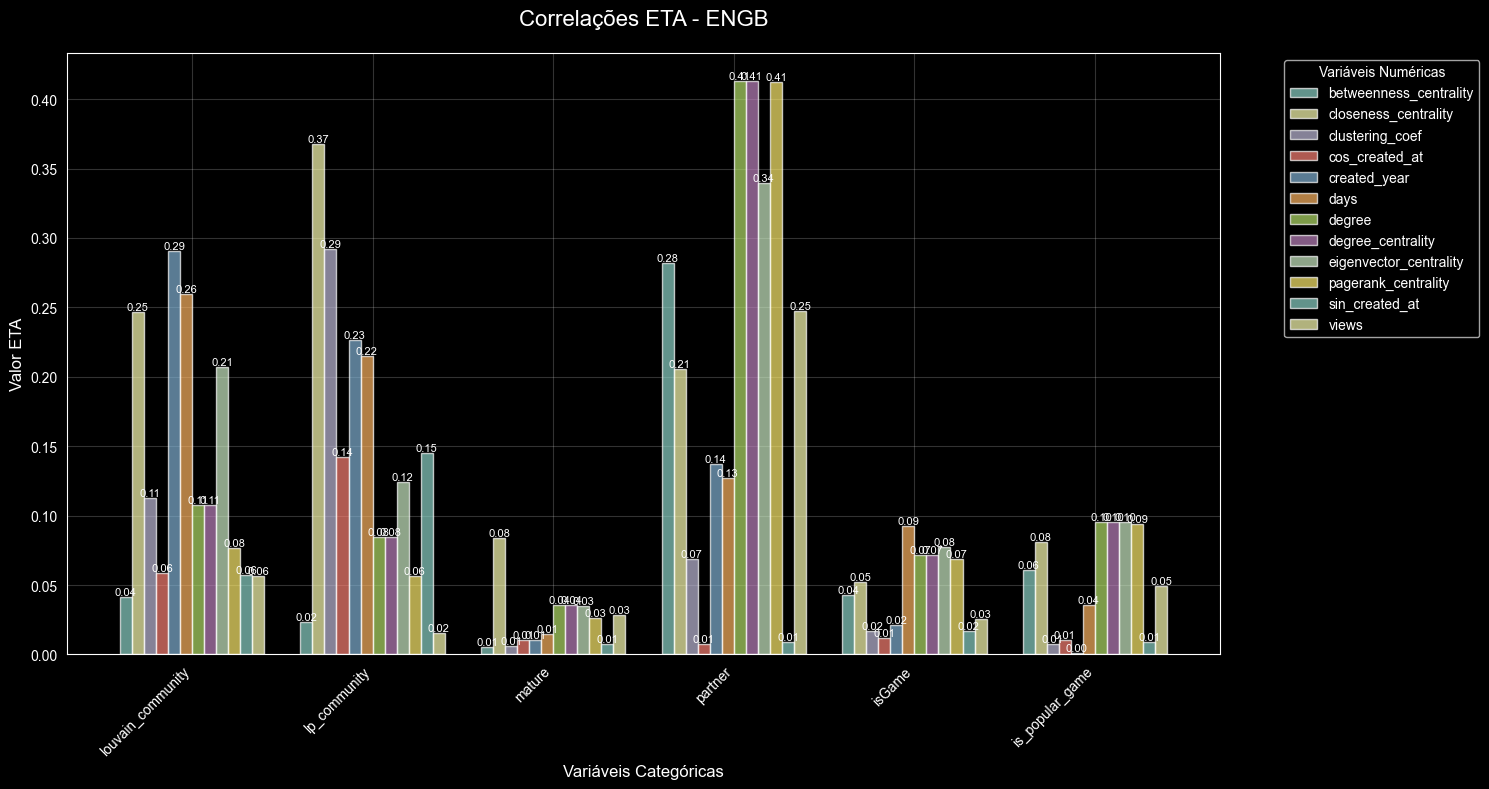

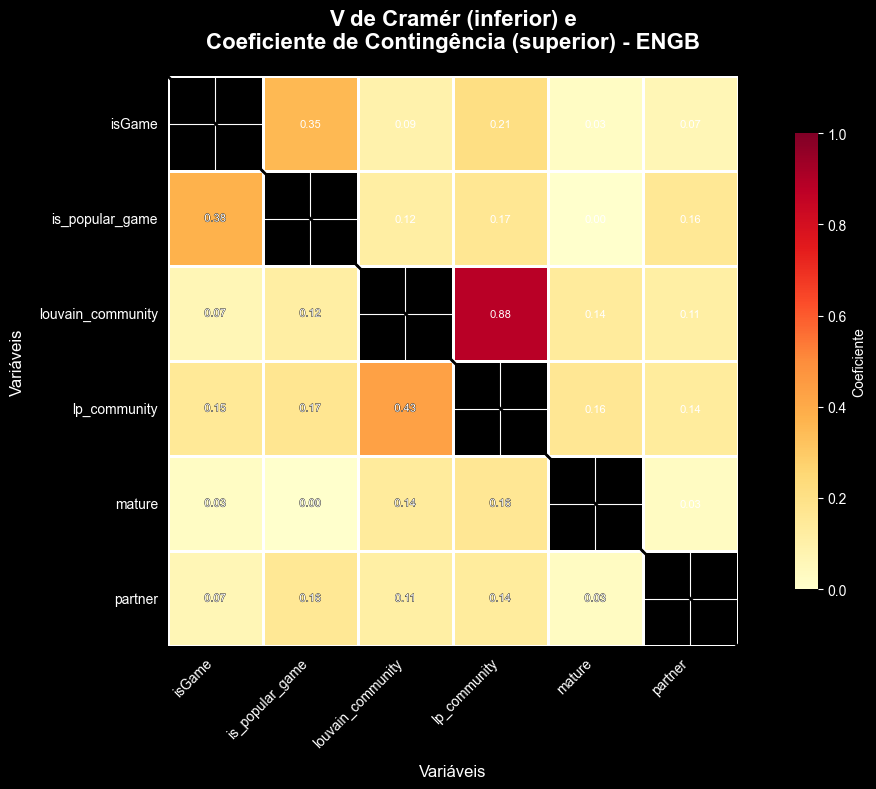

In [128]:
# Calcular correlações
correlations = correlations.calculate_correlations(df, country, output_dir)